In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import json
from tqdm.auto import tqdm
import random
import transformers
import baukit

import os
import sys
sys.path.append('..')

from relations import estimate
from util import model_utils
from baukit import nethook
from operator import itemgetter
from relations.evaluate import evaluate
from relations.corner import CornerEstimator

In [3]:
MODEL_NAME = "EleutherAI/gpt-j-6B"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=True, torch_dtype=torch.float32)

model = mt.model
tokenizer = mt.tokenizer
tokenizer.pad_token = tokenizer.eos_token

print(f"{MODEL_NAME} ==> device: {model.device}, memory: {model.get_memory_footprint()}")

EleutherAI/gpt-j-6B ==> device: cuda:0, memory: 24320971760


In [4]:
mt.ln_f_name

'transformer.ln_f'

In [5]:
corner_estimator = CornerEstimator(
    model = model, tokenizer = tokenizer, ln_f_name = mt.ln_f_name, unembedder_module_name = mt.unembedder_name
)

In [6]:
#################################################
relation_id = "P17"
precision_at = 3
#################################################

with open("../data/counterfact.json") as f:
    counterfact = json.load(f)

objects = [c['requested_rewrite'] for c in counterfact if c["requested_rewrite"]['relation_id'] == relation_id]
objects = [" "+ o['target_true']['str'] for o in objects]
objects = list(set(objects))
objects.append(" China")
print("unique objects: ", len(objects), objects[0:5])

unique objects:  96 [' Albania', ' Poland', ' Rwanda', ' Slovenia', ' Austria']


In [7]:
target_token_ids = tokenizer(objects, padding=True, return_tensors="pt").to(model.device)
target_token_ids = target_token_ids.input_ids.view(len(objects))
target_token_ids.shape

torch.Size([96])

In [56]:
relation = "{} is located in the country of"
subject_o = "Taj Mahal"
subject_i = "Zbuczyn"

prompt_o = relation.format(subject_o)
prompt_i = relation.format(subject_i)

txt, ret_dct = model_utils.generate_fast(
    model, tokenizer,
    prompts = [
        prompt_o, prompt_i
    ],
    argmax_greedy = True,
    get_answer_tokens = True
)

txt, ret_dct['answer']

(['Taj Mahal is located in the country of India. It is a city and a municipal board',
  'Zbuczyn is located in the country of Poland, in the province of Łó'],
 [{'top_token': ' India',
   'candidates': [{'token': ' India', 'token_id': 3794, 'p': 0.7467},
    {'token': ' Pakistan', 'token_id': 7648, 'p': 0.0507},
    {'token': ' Uttar', 'token_id': 44744, 'p': 0.022},
    {'token': ' the', 'token_id': 262, 'p': 0.017},
    {'token': ' Bangladesh', 'token_id': 19483, 'p': 0.0104}]},
  {'top_token': ' Poland',
   'candidates': [{'token': ' Poland', 'token_id': 12873, 'p': 0.6571},
    {'token': ' Belarus', 'token_id': 33368, 'p': 0.0218},
    {'token': ' the', 'token_id': 262, 'p': 0.0201},
    {'token': ' Ukraine', 'token_id': 7049, 'p': 0.0116},
    {'token': ' Lithuania', 'token_id': 31295, 'p': 0.0097}]}])

## Necessary subspace search

In [57]:
def interpret_model_output(output):
    token_ids = output.logits[0][-1].argsort()[-10:]
    logits = output.logits[0][-1][token_ids]
    proba = torch.nn.functional.softmax(output.logits[0][-1], dim = 0)[token_ids]

    return [
        (tokenizer.decode(t), l.item(), p.item()) for t, l, p in zip(token_ids, logits, proba)
    ][::-1]

def get_replace_intervention(
    intervention_layer,
    intervention_token_pos,
    replacement,
):
    def intervention(output, layer):
        if(layer != intervention_layer):
            return output
        output[0][0][intervention_token_pos] = replacement
            
        return output
    
    return intervention

In [58]:
###########################################################
num_basis = 100
intervention_layer = 15
##########################################################

intervention_layer_name = mt.layer_name_format.format(intervention_layer)

In [59]:
tokenized_o = tokenizer(prompt_o, return_tensors = "pt", return_offsets_mapping = True).to(model.device)
offset_mapping = tokenized_o.pop("offset_mapping")
range_o = estimate._find_token_range(
    prompt_o, subject_o, offset_mapping=offset_mapping[0]
)
range_o

(0, 4)

In [60]:
with baukit.TraceDict(
    model, [intervention_layer_name]
) as traces_o:
    output_o = model(**tokenized_o)
interpret_model_output(output_o)

[(' India', 17.919260025024414, 0.7466663718223572),
 (' Pakistan', 15.228890419006348, 0.05066568776965141),
 (' Uttar', 14.396512985229492, 0.022040273994207382),
 (' the', 14.134864807128906, 0.0169662032276392),
 (' Bangladesh', 13.649147033691406, 0.010438548400998116),
 (' Ag', 13.510643005371094, 0.009088424034416676),
 (' Punjab', 13.340045928955078, 0.00766300642862916),
 (' Nepal', 13.251482963562012, 0.007013531867414713),
 (' United', 13.155050277709961, 0.006368785165250301),
 (' Taj', 12.864961624145508, 0.004765107296407223)]

In [61]:
h_o = model_utils.untuple(traces_o[intervention_layer_name].output)[0][range_o[1] - 1]
print(h_o.shape)

corner_estimator.get_vocab_representation(h_o)

torch.Size([4096])


[' Singh', '�', "'s", ' Archives', ' singer']

In [62]:
tokenized_i = tokenizer(prompt_i, return_tensors = "pt", return_offsets_mapping = True).to(model.device)
offset_mapping = tokenized_i.pop("offset_mapping")
range_i = estimate._find_token_range(
    prompt_i, subject_i, offset_mapping=offset_mapping[0]
)
range_i

(0, 5)

In [63]:
with baukit.TraceDict(
    model, [intervention_layer_name]
) as traces_i:
    output_i = model(**tokenized_i)
interpret_model_output(output_i)

[(' Poland', 16.342823028564453, 0.6571455597877502),
 (' Belarus', 12.937439918518066, 0.02181335538625717),
 (' the', 12.856554985046387, 0.020118454471230507),
 (' Ukraine', 12.309950828552246, 0.011646821163594723),
 (' Lithuania', 12.127655029296875, 0.009705934673547745),
 (' �', 11.85157585144043, 0.007364405784755945),
 (' P', 11.803400993347168, 0.007018036674708128),
 (' south', 11.629080772399902, 0.005895346403121948),
 (' K', 11.613897323608398, 0.005806510336697102),
 (' Germany', 11.520854949951172, 0.005290630739182234)]

In [64]:
h_i = model_utils.untuple(traces_i[intervention_layer_name].output)[0][range_i[1] - 1]
print(h_i.shape)

corner_estimator.get_vocab_representation(h_i)

torch.Size([4096])


['nie', 'ew', 'ka', '�', 'ow']

In [65]:
with baukit.TraceDict(
    model, [intervention_layer_name],
    edit_output = get_replace_intervention(
        intervention_layer = intervention_layer_name,
        intervention_token_pos = range_o[1] - 1,
        replacement = h_i
    )
) as traces_c:
    output_c = model(**tokenized_o)

interpret_model_output(output_c)

[(' India', 16.540157318115234, 0.34483572840690613),
 (' Poland', 16.12696647644043, 0.22812126576900482),
 (' Pakistan', 14.928086280822754, 0.06878578662872314),
 (' Taj', 14.263662338256836, 0.03539509326219559),
 (' the', 13.528918266296387, 0.016976485028862953),
 (' Bangladesh', 13.368673324584961, 0.014462863095104694),
 (' Ukraine', 12.944073677062988, 0.009459169581532478),
 (' Bh', 12.827205657958984, 0.008415847085416317),
 (' Punjab', 12.824841499328613, 0.008395974524319172),
 (' Azerbaijan', 12.76975154876709, 0.007945951074361801)]

In [17]:
target_distribution = torch.nn.functional.softmax(output_o.logits[0][-1][[target_token_ids]], dim = 0)
target_distribution.sum()

tensor(1.0000, device='cuda:0')

In [18]:
def make_subspace_normal(Q, num_epochs = 100, learning_rate = 0.001):
    normal_loss = (torch.eye(num_basis).to(model.dtype).to(model.device) - Q.T @ Q).square().sum()
    print(f"initial loss => {normal_loss.item()}")
    
    Q.requires_grad = True
    optimizer = torch.optim.Adam([Q], lr = learning_rate)
    for epoch in tqdm(range(num_epochs)):
        subspace = Q @ Q.T
        normal_loss = (torch.eye(num_basis).to(model.dtype).to(model.device) - Q.T @ Q).square().sum()
        optimizer.zero_grad()
        model.zero_grad()
        normal_loss.backward()
        optimizer.step()
    
    normal_loss = (torch.eye(num_basis).to(model.dtype).to(model.device) - Q.T @ Q).square().sum()
    print(f"final loss => {normal_loss.item()}")
    return Q

In [66]:
intervention_token_pos = range_o[1] - 1  # intervene on the last token of subject

Q = torch.FloatTensor(mt.n_embd, num_basis).uniform_(-.1, .1).to(model.device)
Q.requires_grad = True

In [68]:
####################################
num_epochs = 20
normal_lambda = 10
learning_rate = 0.001
###################################

optimizer = torch.optim.Adam([Q], lr = learning_rate)
kl_loss = torch.nn.KLDivLoss(reduction="batchmean", log_target = True)

loss_track = []
I = torch.eye(mt.n_embd).to(model.dtype).to(model.device)

# Make Q normal before optimizing with KL
Q = make_subspace_normal(Q, num_epochs = 300)


initial = True
for epoch in tqdm(range(num_epochs)):
    
    subspace = Q @ Q.T
    h_c = subspace @ h_o + (I - subspace) @ h_i
    
    with baukit.TraceDict(
        model, [intervention_layer_name],
        edit_output = get_replace_intervention(
            intervention_layer = intervention_layer_name,
            intervention_token_pos = intervention_token_pos,
            replacement = h_c
        )
    ) as traces_c:
        output_c = model(**tokenized_o)
    print(output_c.logits.requires_grad)
        
    if(initial):
        print("initial")
        print(interpret_model_output(output_c))
        initial = False

    predicted_distribution = torch.nn.functional.softmax(output_c.logits[0][-1][[target_token_ids]], dim = 0)
    kl = torch.abs(kl_loss(predicted_distribution, target_distribution))
    normal_loss = (torch.eye(num_basis).to(model.dtype).to(model.device) - Q.T @ Q).square().sum()
    _lambda = normal_lambda * (kl / normal_loss) # make normal loss equivalent to kl loss. otherwise it will swamp kl loss
#     _lambda = normal_lambda
    print(kl.item(), (_lambda*normal_loss).item())
    loss = kl + torch.abs(_lambda*normal_loss) 
    
    loss_track.append(loss.item())
    
    optimizer.zero_grad()
    model.zero_grad()
    loss.backward()
    optimizer.step()

print()
print("Final")
print(interpret_model_output(output_c))

initial loss => 58.751220703125


  0%|          | 0/300 [00:00<?, ?it/s]

final loss => 3.8020595786308897e-13


  0%|          | 0/20 [00:00<?, ?it/s]

True
initial
[(' China', 19.67629051208496, 0.925338089466095), (' India', 15.391878128051758, 0.012752748094499111), (' the', 14.588817596435547, 0.005712668411433697), (' Myanmar', 13.963502883911133, 0.003056808840483427), (' Yun', 13.613762855529785, 0.0021546566858887672), (' Chin', 13.56003189086914, 0.002041940577328205), (' People', 13.361471176147461, 0.0016742073930799961), (' North', 13.28667163848877, 0.0015535462880507112), ('\n', 13.205667495727539, 0.001432664692401886), (' G', 13.17929458618164, 0.0013953750021755695)]
0.00023856665939092636 0.0023856668267399073
True
7.716646359767765e-05 0.000771664606872946
True
7.171423203544691e-05 0.0007171423058025539
True
1.1788135452661663e-05 0.00011788135452661663
True
7.589104643557221e-05 0.0007589104352518916
True
7.69668331486173e-05 0.0007696683751419187
True
7.705959433224052e-05 0.0007705959142185748
True
7.706705218879506e-05 0.0007706705364398658
True
7.705660391366109e-05 0.0007705660536885262
True
7.7033371780999e-

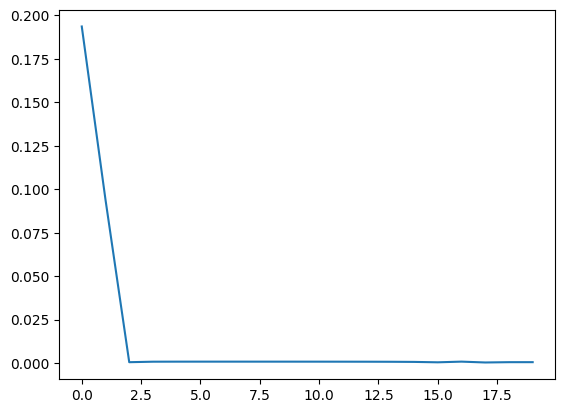

In [22]:
import matplotlib.pyplot as plt

plt.plot(loss_track)

(0.0, 1.0)

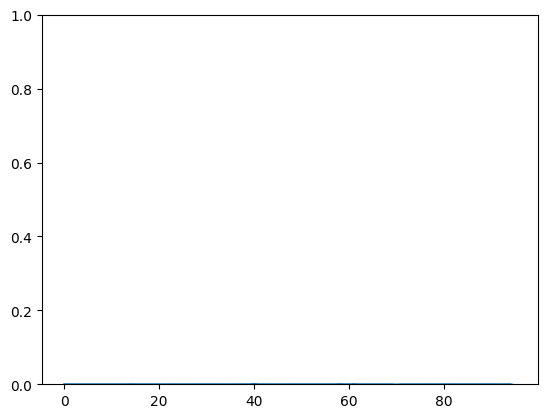

In [23]:
plt.plot((target_distribution - predicted_distribution).detach().cpu().numpy())
plt.ylim(0, 1)

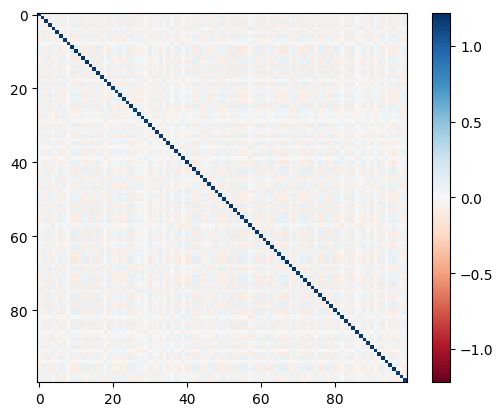

In [24]:
from util import misc

misc.visualize_matrix((Q.T @ Q).detach().cpu())

In [25]:
(torch.eye(num_basis).to(model.dtype).to(model.device) - Q.T@Q).square().sum().item()

47.13986587524414

In [ ]:
misc.visualize_matrix((Q @ Q.T).detach().cpu())